# Importing Necessary Libraries

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import tqdm 
import matplotlib.pyplot as plt

# Fix a key as a seed

In [3]:
key = jax.random.PRNGKey(seed = 0)

# System parameters

In [4]:
NUM_ARMS = 20
NUM_FEATURES = 5
NUM_STEPS = int(1e+3)
ALPHA = 0.1
BEST_ARMS = jnp.array([3, 7, 9, 15])

# Data Generators

In [5]:
@jax.jit
def make_design_matrix():
    X = jax.random.uniform(key,shape = (NUM_STEPS,NUM_ARMS,NUM_FEATURES))
    return X

@jax.jit
def make_theta(bias = 1):
    true_theta = jax.random.normal(key,shape=(NUM_ARMS,NUM_FEATURES))*(0.25)
    true_theta =  true_theta.at[BEST_ARMS,:].add(bias)
    return true_theta

@jax.jit
def generate_reward(arm, x, theta, scale_noise = 1.0/10.0):
    signal = jnp.dot(theta[arm], x)
    noise = jax.random.normal(key)*scale_noise
    return signal + noise

@jax.jit
def make_regret(payoffs, oracles):
    return jnp.cumsum(oracles - payoffs)

In [6]:
X = make_design_matrix()
true_theta = make_theta()

payoffs = jnp.array([[generate_reward(arm=arm, x=X[t, arm], theta=true_theta) for arm in jnp.arange(NUM_ARMS)] for t in jnp.arange(NUM_STEPS)])
ave_rewards = jnp.mean(payoffs, axis=0)

# Simple Visualization

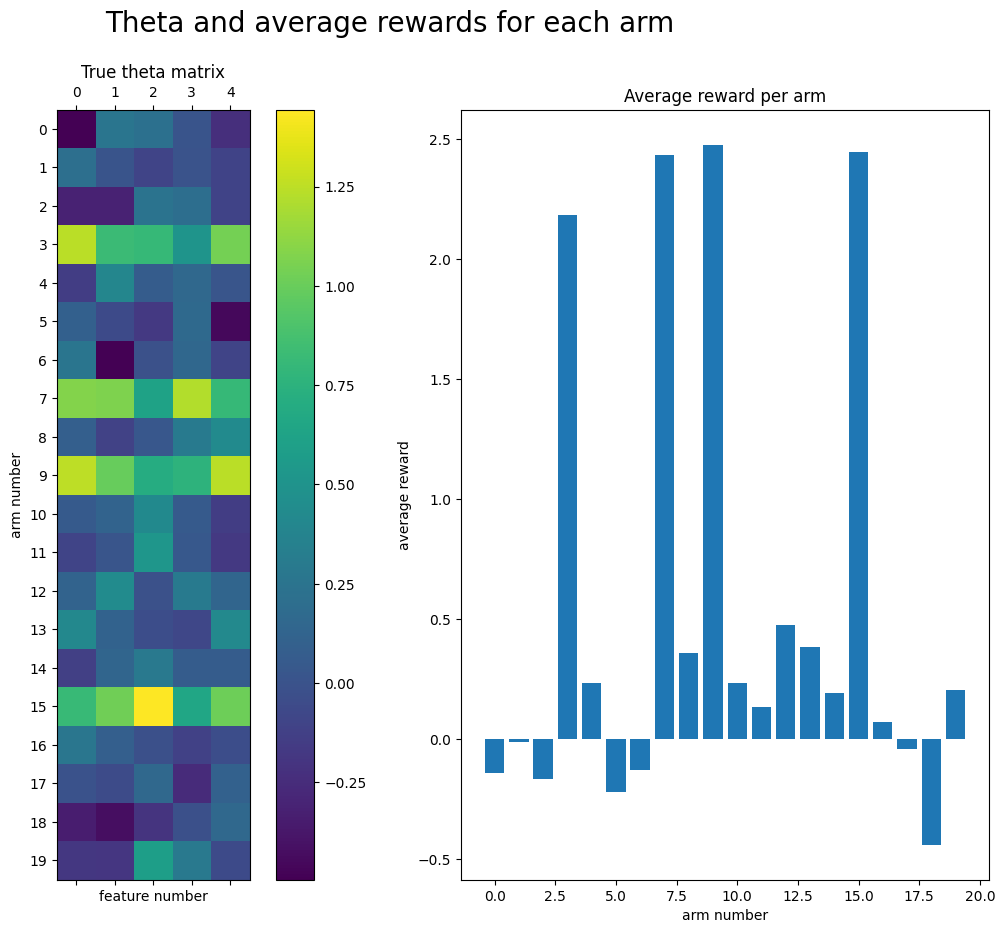

In [7]:
f, (theta_fig, avg_reward_fig) = plt.subplots(1, 2, figsize=(15, 10))
f.suptitle("Theta and average rewards for each arm", fontsize=20)
# Visualizing true theta
theta_fig.matshow(true_theta)
f.colorbar(theta_fig.imshow(true_theta), ax = theta_fig)
theta_fig.set_xlabel("feature number")
theta_fig.set_ylabel("arm number")
theta_fig.set_yticks(np.arange(NUM_ARMS))
theta_fig.set_title("True theta matrix")

# Visualizing avewrage reward
avg_reward_fig.bar(np.arange(NUM_ARMS), ave_rewards)
avg_reward_fig.set_title("Average reward per arm")
avg_reward_fig.set_xlabel("arm number")
avg_reward_fig.set_ylabel("average reward")
plt.show()

# Linear Upper Confidence Bound

In [8]:

def lin_ucb(alpha, X, generate_reward, true_theta):
    n_trials, n_arms, n_features = X.shape
    arm_choice = jnp.zeros(n_trials)
    r_payoffs = jnp.zeros(n_trials) 
    theta_hat = jnp.zeros(shape=(n_arms, n_features)) 
    p = jnp.zeros(shape=(n_trials, n_arms)) 
    
    A = jnp.array([jnp.identity(n=n_features) for _ in jnp.arange(n_arms)])
    b = jnp.array([jnp.zeros(shape=n_features) for _ in jnp.arange(n_arms)]) 
    
    for t in tqdm.tqdm(range(n_trials)):
        for a in range(n_arms):
            inv_A = jnp.linalg.inv(A[a])
            theta_hat = theta_hat.at[a].set(jnp.dot(inv_A,b[a])) 
            p = p.at[(t,), (a,)].set(theta_hat[a].dot(X[t][a]) + alpha * jnp.sqrt(X[t][a].dot(inv_A).dot(X[t][a])))

        chosen_arm = jnp.argmax(p[t])
        x_chosen_arm = X[t, chosen_arm]
        r_payoffs = r_payoffs.at[t].set(generate_reward(arm=chosen_arm, x = x_chosen_arm, theta=true_theta))
        arm_choice = arm_choice.at[t].set(chosen_arm)
        
        A = A.at[chosen_arm].add(np.outer(x_chosen_arm, x_chosen_arm.T))
        b = b.at[chosen_arm].add(r_payoffs[t]*x_chosen_arm)
    return dict(theta=theta_hat, p=p, arm_choice=arm_choice, r_payoffs = r_payoffs)

# def lin_ucb_hybrid(alpha, X, generate_reward, true_theta):
#     n_trials, n_arms, n_features = X.shape
#     k = n_arms*n_features
#     arm_choice = jnp.zeros(n_trials)
#     r_payoffs = jnp.zeros(n_trials) 
#     theta_hat = jnp.zeros(shape=(n_arms, n_features)) 
#     p = jnp.zeros(shape=(n_trials, n_arms)) 
    
#     A0 = jnp.identity(n=k)
#     b0 = jnp.zeros(k)
    
#     A = jnp.array([jnp.identity(n=n_features) for _ in jnp.arange(n_arms)])
#     B = jnp.array([jnp.zeros(shape=(n_features,k)) for _ in jnp.arange(n_arms)])
#     b = jnp.array([jnp.zeros(shape=n_features) for _ in jnp.arange(n_arms)]) 
    
#     for t in tqdm.tqdm(range(n_trials)):
#         beta_hat = jnp.linalg.inv(A0).dot(b0)
#         for a in range(n_arms):
#             inv_A = jnp.linalg.inv(A[a])
#             theta_hat = theta_hat.at[a].set(jnp.dot(inv_A,b[a])) 
#             p = p.at[(t,), (a,)].set(theta_hat[a].dot(X[t][a]) + alpha * jnp.sqrt(X[t][a].dot(inv_A).dot(X[t][a])))

#         chosen_arm = jnp.argmax(p[t])
#         x_chosen_arm = X[t, chosen_arm]
#         r_payoffs = r_payoffs.at[t].set(generate_reward(arm=chosen_arm, x = x_chosen_arm, theta=true_theta))
#         arm_choice = arm_choice.at[t].set(chosen_arm)
        
#         A = A.at[chosen_arm].add(np.outer(x_chosen_arm, x_chosen_arm.T))
#         b = b.at[chosen_arm].add(r_payoffs[t]*x_chosen_arm)
#     return dict(theta=theta_hat, p=p, arm_choice=arm_choice, r_payoffs = r_payoffs)

In [9]:
oracles = jnp.array([np.max([generate_reward(arm=arm, x=X[t, arm], theta=true_theta) for arm in range(NUM_ARMS)]) for t in range(NUM_STEPS)])

In [10]:
random_payoffs = jnp.array([generate_reward(arm=jax.random.choice(key,NUM_ARMS), x = X[t, jax.random.choice(key,NUM_ARMS)], theta=true_theta) for t in range(NUM_STEPS)])

In [11]:
random_regrets = make_regret(payoffs=random_payoffs, oracles=oracles)

In [12]:
alphas = [0, 1, 2.5, 5, 10, 20]
results_dict = {alpha: lin_ucb(alpha=alpha, X = X, generate_reward=generate_reward, true_theta=true_theta) for alpha in alphas}

100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


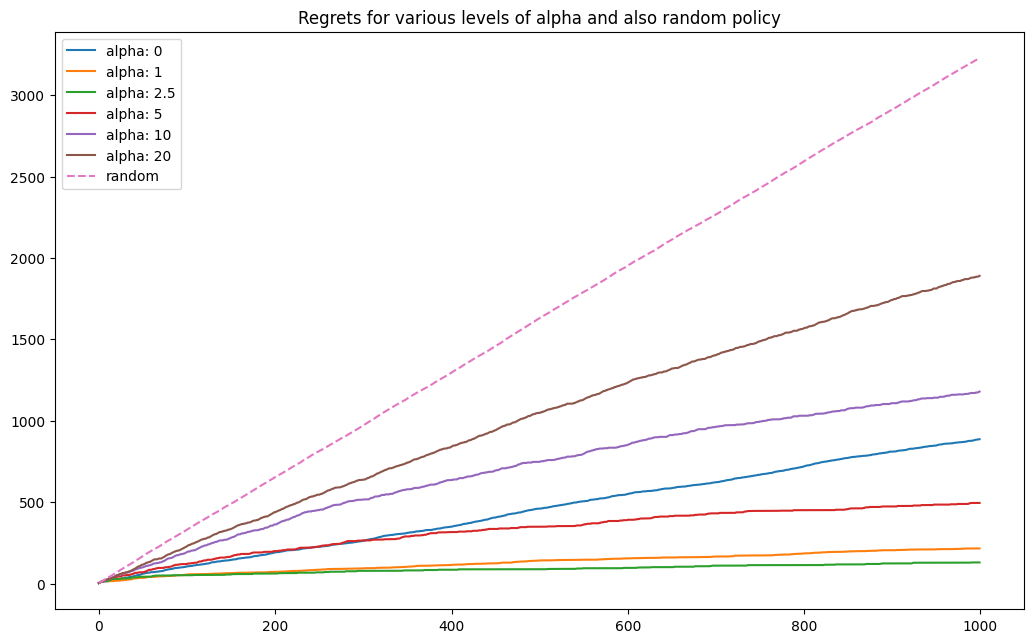

In [13]:
def plot_regrets(results, oracles):
    [plt.plot(make_regret(payoffs=x['r_payoffs'], oracles=oracles), label="alpha: " + str(alpha)) for (alpha, x) in results.items()]
    
plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, oracles)
# plot also the random one
plt.plot(make_regret(random_payoffs, oracles), label='random', linestyle='--')
plt.legend()
plt.title("Regrets for various levels of alpha and also random policy")
plt.show()

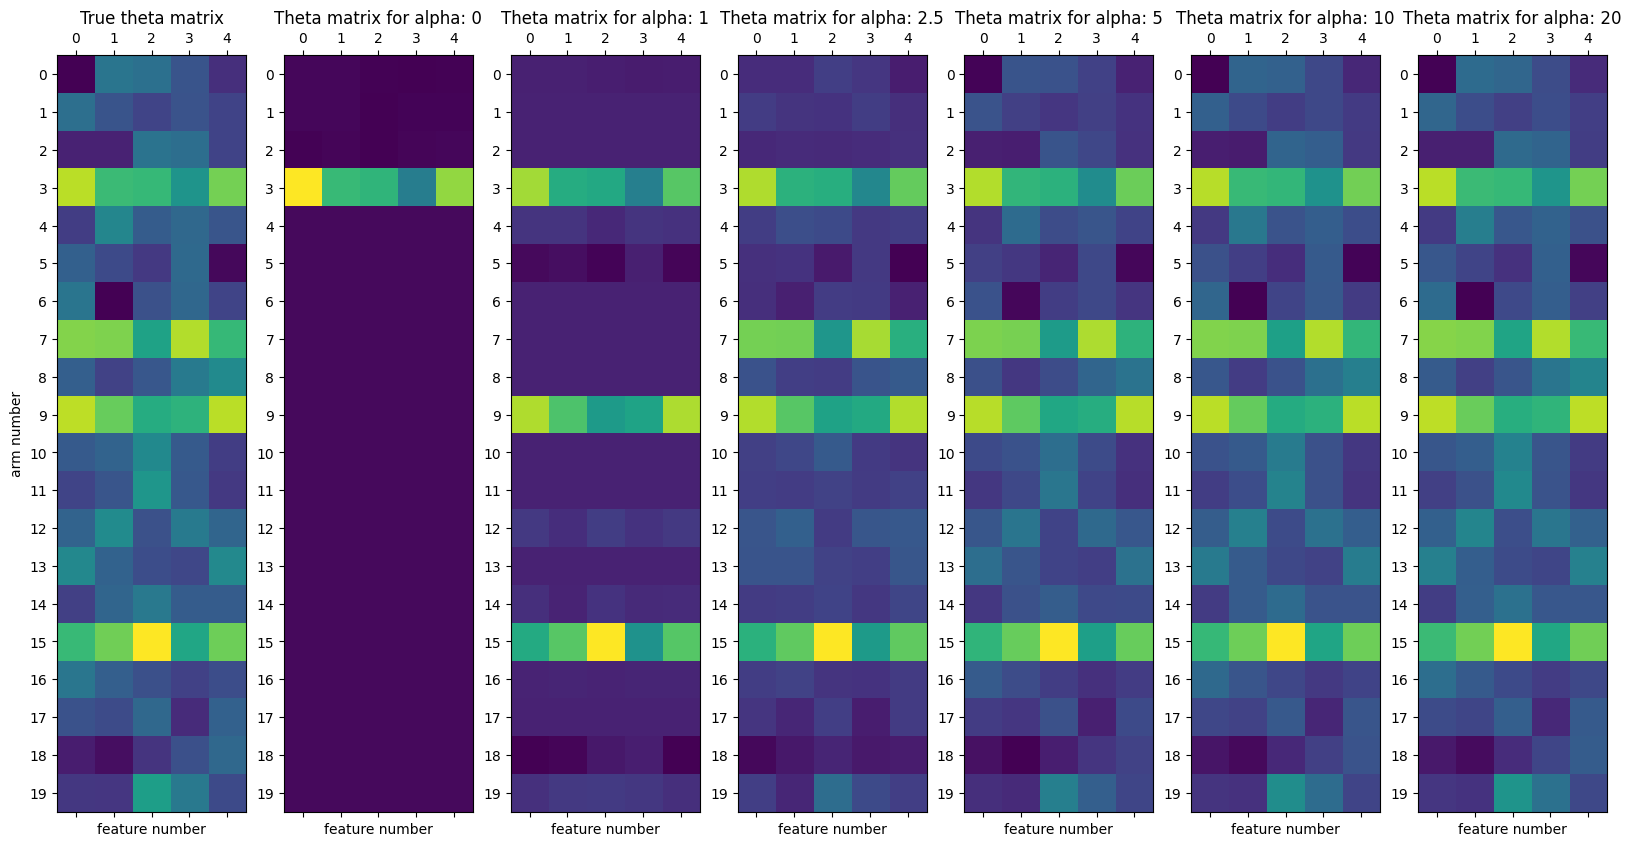

In [14]:
fig,axs = plt.subplots(1,7, figsize=(20, 10))
thetas = [true_theta] + [results_dict[i]['theta'] for i in results_dict.keys()]

axs[0].set_ylabel("arm number")
for i,theta in enumerate(thetas):
    axs[i].matshow(theta)
    axs[i].set_xlabel("feature number")
    axs[i].set_yticks(np.arange(NUM_ARMS))
    if i == 0:
        axs[i].set_title("True theta matrix")
    else:
        axs[i].set_title("Theta matrix for alpha: {}".format(list(results_dict.keys())[i-1]))

fig.colorbar(theta_fig.imshow(true_theta), ax = theta_fig)
plt.show()


In [35]:
results_dict.keys()

dict_keys([0, 1, 2.5, 5, 10, 20])

In [ ]:
f, (theta_fig, avg_reward_fig) = plt.subplots(1, 2, figsize=(15, 10))
f.suptitle("Theta and average rewards for each arm", fontsize=20)
# Visualizing true theta
theta_fig.matshow(true_theta)
f.colorbar(theta_fig.imshow(true_theta), ax = theta_fig)
theta_fig.set_xlabel("feature number")
theta_fig.set_ylabel("arm number")
theta_fig.set_yticks(np.arange(NUM_ARMS))
theta_fig.set_title("True theta matrix")

# Visualizing avewrage reward
avg_reward_fig.bar(np.arange(NUM_ARMS), ave_rewards)
avg_reward_fig.set_title("Average reward per arm")
avg_reward_fig.set_xlabel("arm number")
avg_reward_fig.set_ylabel("average reward")
plt.show()